## The Markowitz Portfolio Allocation Problem: Risky Assets Only
[Markowitz portfolio allocation](https://en.wikipedia.org/wiki/Markowitz_model) identifies the weights $w$'s for assets in a portfolio such that the portfolio variance (risk) is minimized for a specified rate of portfolio return (reward). The Markowitz allocation problem for a portfolio $\mathcal{P}$ composed of only risky assets is given by:

\begin{eqnarray*}
\text{minimize}~\sigma_{\mathcal{P}}^2 &=& \sum_{i\in\mathcal{P}}\sum_{j\in\mathcal{P}}w_{i}w_{j}
\text{cov}\left(r_{i},r_{j}\right) \\
\text{subject to}~\mathbb{E}(r_{\mathcal{P}})& = & \sum_{i\in\mathcal{P}}w_{i}\cdot\mathbb{E}(r_{i})\geq{R^{*}}\\
\sum_{i\in\mathcal{P}}\omega_{i} & = & 1\\
\text{and}~w_{i}&\geq&{0}\qquad{\forall{i}\in\mathcal{P}}
\end{eqnarray*}

The term $w_{i}\geq{0}$ denotes the fraction of asset $i$ in the portfolio $\mathcal{P}$, $R^{*}$ is the minimal required return for $\mathcal{P}$, $\sigma_{\mathcal{P}}$ denotes the portfolio variance, $r_{i}$ denotes the return for asset $i$ and $\text{cov}\left(r_{i},r_{j}\right)$ denotes [covariance](https://en.wikipedia.org/wiki/Covariance) between the return of asset $i$ and $j$ in the portfolio. The non-negativity of the fractions $w_{i}$ forbids short selling. This constraint can be relaxed if borrowing is allowed. 

### Learning objectives
In this example, we'll compute the [Efficient Frontier](https://en.wikipedia.org/wiki/Efficient_frontier) for a portfolio of risky assets, where the expected return and the covariance of the returns are calculated from a historical dataset. 

* First, we'll load the historical dataset. The data we'll explore is daily open-high-low-close values for firms in the [S&P500 index](https://en.wikipedia.org/wiki/S%26P_500) over the last five years.
* Next, we'll compute the expected returns and the covariance arrays from the historical dataset
* Finally, we'll compute the efficient frontier by solving the optimization problem described above: minimize the risk for a specified minimum reward value.

### Setup

In [1]:
using Pkg
Pkg.add(path="https://github.com/varnerlab/VLDecisionsPackage.jl.git")

    Updating git-repo `https://github.com/varnerlab/VLDecisionsPackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-5760-Examples-F23/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5760-Examples-F23/Manifest.toml`


In [1]:
include("Include.jl");

  Activating project at `~/Desktop/julia_work/CHEME-5760-Examples-F23`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLDecisionsPackage.jl.git`
  No Changes to `~/Desktop/julia_work/CHEME-5760-Examples-F23/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5760-Examples-F23/Manifest.toml`


## Task 1: Load the historical dataset
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) for the past five-trading years (a maximum of `1256` data points per firm). However, not all the firms in the `dataset` have the maximum number of trading days, i.e., some firms are missing information for various reasons; perhaps they were acquired, merged, or delisted, etc. We will exclude these firms from the `dataset`.

We load the price `dataset` by calling the `MyPortfolioDataSet()` function:

In [2]:
dataset = MyPortfolioDataSet() |> x-> x["dataset"];

In [15]:
typeof(dataset)

Dict{Int64, DataFrame}

Each firm is assigned an `index` (the `keys` of the `dataset` dictionary). Let's get these `keys`, sort them, and then store these firm indices in the `firms` array:

In [3]:
firms = keys(dataset) |> collect |> sort;

Finally, we set some constant values that are used in the computation of the efficient frontier:

In [4]:
number_of_firms = length(firms);
bounds = zeros(number_of_firms,2);
bounds[:,2] .= 1.0;
wₒ = zeros(number_of_firms);
wₒ[1] = 1.0;
Rₒ = 0.001;
number_of_points = 20;

### Compute the expected return and covariance matrices
First, we compute the expected (annualized) log return by passing the `dataset` and a list of firms we are interested in (held in the $N\times{1}$ `firms` array) to the `log_return_matrix(...)` method. The result is stored in the `return_matrix` variable, a $T-1\times{N}$ array of log return values. 
Each row of `return_matrix` corresponds to a time-value, while each column corresponds to a firm:  

In [5]:
return_matrix = log_return_matrix(dataset,firms);

In [16]:
return_matrix

1255×458 Matrix{Float64}:
  3.98333     1.47923    0.746226   …  -0.93186    1.79882    2.05452
  1.0048      2.36635   -0.436171       1.90109   -0.711936   2.9759
  0.392145    1.88487   -0.427924       1.41242   -0.355978   2.46921
  1.34651     0.61258    0.20056       -1.14283    5.1484     3.41373
  0.0338528   0.217766  -0.45835       -6.04605    3.3669    -4.87013
  0.225465    3.42912    0.0467736  …  -1.13673    2.24034    2.48203
  3.38755     3.36414    0.77586        0.107606   2.39702    3.15105
  0.468374    1.10531   -1.59759       -0.255148  -1.55483    1.107
  2.75286     0.334687   1.72247        0.828752  -0.102035   2.84631
 -1.76915     1.13233   -0.0158197     -0.358324  -0.505564  -1.09091
  1.36128     3.20018    1.44276    …   2.89913    2.28925    0.992827
 -0.741513    0.561674  -0.140758       3.70966    1.8914     1.48424
 -0.53336    -0.335797   0.110146      -1.11689    1.40743    1.8296
  ⋮                                 ⋱   ⋮                    
 -2.2

Next, we estimate the `covariance_matrix` from the `return_matrix` using the `cov(...)` function which is exported by the [Statistics.jl package](https://docs.julialang.org/en/v1/stdlib/Statistics/): 

In [6]:
covariance_matrix = cov(return_matrix);

In [17]:
covariance_matrix

458×458 Matrix{Float64}:
 14.3734    8.85069   5.9015    5.43542  …   8.10422  10.1054     6.06202
  8.85069  17.848     5.68238   4.277        7.69141  10.9112     6.32871
  5.9015    5.68238  13.3729    6.18499      7.44477   5.15959    8.55697
  5.43542   4.277     6.18499  17.9445       7.52029   6.14497    6.71
  8.04019   8.07385   8.20575   6.95048     10.3932   10.4342    10.0788
  2.82115   3.4607    4.87898   4.16995  …   3.281     0.702594   4.68175
  6.67121   6.30362   4.39656   4.87928      8.12056  11.0726     5.01026
  5.58546   6.56366   8.49889   5.94821      9.1549    5.13129   10.7614
  7.24133   8.2889    4.74096   5.96071      9.26652  10.6733     7.83041
  8.77197   9.37396  10.2236    6.45547     11.9016    9.68968   11.481
  7.15101   8.2505    5.51011   6.59953  …  13.0621   12.8317     8.29613
  8.47542   8.27172   5.50736   6.62881     12.8302   15.409      7.84002
  6.7686    7.51399   8.82169   6.01834      9.24965   8.23665    9.74956
  ⋮                 

Finally, we estimate the expected return for each firm from the `return_matrix` using the `mean(...)` function which is exported by the [Statistics.jl package](https://docs.julialang.org/en/v1/stdlib/Statistics/): 

In [7]:
tmp = mean(return_matrix, dims=1);
expected_return = Array{Float64,1}()
for i ∈ 1:number_of_firms
    push!(expected_return, tmp[i])
end

### Compute the Efficient Frontier
First, let's create an instance of the `MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem` type, and store this in the `problem` variable, using the `build(...)` method. We pass the covariance array estimated from data, and the expected return value, along with bounds and an initial guess to the `build(...)` method:

In [8]:
problem = build(MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem, (
    Σ = covariance_matrix,
    μ = expected_return,
    bounds = bounds,
    initial = wₒ,
    R = 0.0
));

Next, we create an array with the minimum desired rewards (the calculation must achieve at least this much reward). We store these values in the `minimum_desired_reward_array` variable:

In [9]:
minimum_desired_reward_array = range(Rₒ,stop = 0.5, length = number_of_points) |> collect;

Finally, we iterate through the `minimum_desired_reward_array` and compute the minimum risk required to achieve the specified reward level using a `for-loop`. In particular, for each pass through the loop, we:
* Update the `problem` variable with the minimum desired reward
* We then pass the updated `problem` object to the `solve(...)` method (which initializes and solves the optimization problem). The solution returned from the `solve(...)` method is stored in the `solution` dictionary. 
* We check the `status` of the solution. If the `status` indicates an optimal solution was found, we store the solution in the `frontier` dictionary.

In [19]:
frontier = Dict{Float64,Float64}();
for i ∈ eachindex(minimum_desired_reward_array)
    
    # update the problem object -
    problem.R = minimum_desired_reward_array[i];
    
    # compute -
    solution = solve(problem)

    # check: did this converge?
    status_flag = solution["status"];    
    if (status_flag == MathOptInterface.LOCALLY_SOLVED)
        key = solution["objective_value"];
        value = solution["reward"];
        frontier[key] = value;
    end
end

In [20]:
frontier

Dict{Float64, Float64} with 20 entries:
  8.03708 => 0.316158
  4.90805 => 0.211105
  3.60642 => 0.106053
  22.0202 => 0.5
  12.4047 => 0.394947
  3.35694 => 0.0535263
  6.16667 => 0.263632
  4.45612 => 0.184842
  3.32937 => 0.0336025
  3.81958 => 0.132316
  5.47174 => 0.237368
  9.26778 => 0.342421
  4.1006  => 0.158579
  14.3433 => 0.421211
  19.1156 => 0.473737
  10.7205 => 0.368684
  3.45399 => 0.0797895
  16.5701 => 0.447474
  7.01571 => 0.289895
  3.32937 => 0.0336024

### Visualize the Efficient Frontier

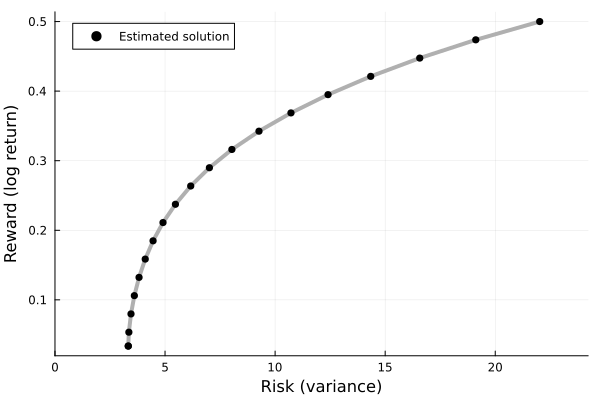

In [21]:
plot(frontier, lw=4, xlabel="Risk (variance)", 
    ylabel="Reward (log return)", fontsize=18, label="", c=:gray69, 
    xlim=(0.0, 1.1*maximum(frontier).first))
scatter!(frontier, label="Estimated solution", c=:black)